# NewfeaturesV2: Incremental Training Algorithm
## Reference:
- https://www.icode9.com/content-1-376184.html
- https://zhuanlan.zhihu.com/p/41422048
- http://www.huaxiaozhuan.com/%E5%B7%A5%E5%85%B7/lightgbm/chapters/lightgbm_usage.html
- https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import random
import pandas as pd
import joblib
import psutil
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
# import riiideducation
from sklearn.metrics import roc_auc_score
import gc

_ = np.seterr(divide='ignore', invalid='ignore')

# Preprocess

In [2]:
data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id':'int8', 
    'task_container_id': 'int16',
    #'user_answer': 'int8',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [3]:
print('start read train data...')
train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()

start read train data...


In [4]:
print('start handle lecture data...')

start handle lecture data...


In [5]:
#reading in lecture df
lectures_df = pd.read_csv('../input/riiid-test-answer-prediction/lectures.csv')

In [6]:
lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')

lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])

part_lectures_columns = [column for column in lectures_df.columns if column.startswith('part')]

types_of_lectures_columns = [column for column in lectures_df.columns if column.startswith('type_of_')]

In [7]:
train_lectures = train_df[train_df.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')

In [8]:
user_lecture_stats_part = train_lectures.groupby('user_id',as_index = False)[part_lectures_columns + types_of_lectures_columns].sum()

In [9]:
lecturedata_types_dict = {   
    'user_id': 'int32', 
    'part_1': 'int8',
    'part_2': 'int8',
    'part_3': 'int8',
    'part_4': 'int8',
    'part_5': 'int8',
    'part_6': 'int8',
    'part_7': 'int8',
    'type_of_concept': 'int8',
    'type_of_intention': 'int8',
    'type_of_solving_question': 'int8',
    'type_of_starter': 'int8'
}
user_lecture_stats_part = user_lecture_stats_part.astype(lecturedata_types_dict)

In [10]:
for column in user_lecture_stats_part.columns:
    #bool_column = column + '_boolean'
    if(column !='user_id'):
        user_lecture_stats_part[column] = (user_lecture_stats_part[column] > 0).astype('int8')

In [11]:
#clearing memory
del(train_lectures)
gc.collect()

120

In [12]:
user_lecture_agg = train_df.groupby('user_id')['content_type_id'].agg(['sum', 'count'])
user_lecture_agg=user_lecture_agg.astype('int16')

In [13]:
#1= if the event was the user watching a lecture.
cum = train_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
cum['cumcount']=cum['cumcount']+1
train_df['user_interaction_count'] = cum['cumcount'] 
train_df['user_interaction_timestamp_mean'] = train_df['timestamp']/cum['cumcount'] 
train_df['user_lecture_sum'] = cum['cumsum'] 
train_df['user_lecture_lv'] = cum['cumsum'] / cum['cumcount']


train_df.user_lecture_lv=train_df.user_lecture_lv.astype('float16')
train_df.user_lecture_sum=train_df.user_lecture_sum.astype('int16')
train_df.user_interaction_count=train_df.user_interaction_count.astype('int16')
train_df['user_interaction_timestamp_mean']=train_df['user_interaction_timestamp_mean']/(1000*3600)
train_df.user_interaction_timestamp_mean=train_df.user_interaction_timestamp_mean.astype('float32')


In [14]:
del cum
gc.collect()

40

In [15]:
print('start handle train_df...')

start handle train_df...


In [16]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)
train_df = train_df[train_df[target] != -1].reset_index(drop=True)

In [17]:
content_explation_agg=train_df[["content_id","prior_question_had_explanation",target]].groupby(["content_id","prior_question_had_explanation"])[target].agg(['mean'])

In [18]:
content_explation_agg=content_explation_agg.unstack()

content_explation_agg=content_explation_agg.reset_index()
content_explation_agg.columns = ['content_id', 'content_explation_false_mean','content_explation_true_mean']

In [19]:
content_explation_agg.content_id=content_explation_agg.content_id.astype('int16')
content_explation_agg.content_explation_false_mean=content_explation_agg.content_explation_false_mean.astype('float16')
content_explation_agg.content_explation_true_mean=content_explation_agg.content_explation_true_mean.astype('float16')

In [20]:
print('start handle attempt_no...')

start handle attempt_no...


In [21]:
train_df["attempt_no"] = 1
train_df.attempt_no=train_df.attempt_no.astype('int8')
#
attempt_no_agg=train_df.groupby(["user_id","content_id"])["attempt_no"].agg(['sum']).astype('int8')
#attempt_no_agg=attempt_no_agg.astype('int8')
train_df["attempt_no"] = train_df[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()

In [22]:
attempt_no_agg=attempt_no_agg[attempt_no_agg['sum'] >1]

In [23]:
print('start handle timestamp...')
prior_question_elapsed_time_mean=train_df['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)

start handle timestamp...


In [24]:
max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u.columns = ['user_id', 'max_time_stamp']
max_timestamp_u.user_id=max_timestamp_u.user_id.astype('int32')

In [25]:
train_df['lagtime'] = train_df.groupby('user_id')['timestamp'].shift()

max_timestamp_u2 = train_df[['user_id','lagtime']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u2.columns = ['user_id', 'max_time_stamp2']
max_timestamp_u2.user_id=max_timestamp_u2.user_id.astype('int32')

In [26]:
train_df['lagtime']=train_df['timestamp']-train_df['lagtime']
lagtime_mean=train_df['lagtime'].mean()
train_df['lagtime'].fillna(lagtime_mean, inplace=True)

In [27]:
train_df['lagtime']=train_df['lagtime']/(1000*3600)
train_df.lagtime=train_df.lagtime.astype('float32')

In [28]:
train_df['lagtime2'] = train_df.groupby('user_id')['timestamp'].shift(2)

max_timestamp_u3 = train_df[['user_id','lagtime2']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u3.columns = ['user_id', 'max_time_stamp3']
max_timestamp_u3.user_id=max_timestamp_u3.user_id.astype('int32')

train_df['lagtime2']=train_df['timestamp']-train_df['lagtime2']
lagtime_mean2=train_df['lagtime2'].mean()
train_df['lagtime2'].fillna(lagtime_mean2, inplace=True)


In [29]:
train_df['lagtime2']=train_df['lagtime2']/(1000*3600)
train_df.lagtime2=train_df.lagtime2.astype('float32')

In [30]:

train_df['lagtime3'] = train_df.groupby('user_id')['timestamp'].shift(3)

train_df['lagtime3']=train_df['timestamp']-train_df['lagtime3']
lagtime_mean3=train_df['lagtime3'].mean()
train_df['lagtime3'].fillna(lagtime_mean3, inplace=True)
train_df['lagtime3']=train_df['lagtime3']/(1000*3600)
train_df.lagtime3=train_df.lagtime3.astype('float32')

In [31]:
train_df['timestamp']=train_df['timestamp']/(1000*3600)
#
train_df.timestamp=train_df.timestamp.astype('float16')

In [32]:
user_prior_question_elapsed_time = train_df[['user_id','prior_question_elapsed_time']].groupby(['user_id']).tail(1)
user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']

In [33]:
train_df['question_elapsed_time'] = train_df['prior_question_elapsed_time'].shift(-1)
train_df['question_elapsed_time'] = train_df['question_elapsed_time'].astype('float16')
train_df['delta_prior_question_elapsed_time'] = train_df.groupby('user_id')['prior_question_elapsed_time'].shift()
train_df['delta_prior_question_elapsed_time']=train_df['prior_question_elapsed_time']-train_df['delta_prior_question_elapsed_time']

In [34]:
content_elapsed_time_agg=train_df.loc[train_df[target] == 1]
content_elapsed_time_agg=content_elapsed_time_agg.groupby('content_id')['question_elapsed_time'].agg(['median','mean','max','min','skew','var'])
content_elapsed_time_agg=content_elapsed_time_agg.astype('float16')
content_had_explanation_agg=train_df.groupby('content_id')['prior_question_had_explanation'].agg(['mean'])
content_had_explanation_agg=content_had_explanation_agg.astype('float16')
del train_df['question_elapsed_time']
gc.collect()

40

In [35]:
delta_prior_question_elapsed_time_mean=train_df['delta_prior_question_elapsed_time'].mean()
train_df['delta_prior_question_elapsed_time'].fillna(delta_prior_question_elapsed_time_mean, inplace=True)
train_df.delta_prior_question_elapsed_time=train_df.delta_prior_question_elapsed_time.astype('int32')

In [36]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()

cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
##cum['cumcount']=cum['cumcount']+1
user_agg = train_df.groupby('user_id')['lag'].agg(['sum', 'count']).astype('int16')
cum['cumsum'].fillna(0, inplace=True)

train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df['user_correct_count'] = cum['cumsum']
train_df['user_uncorrect_count'] = cum['cumcount']-cum['cumsum']
#train_df['user_answer_count'] = cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)
train_df['user_correctness'].fillna(0.67, inplace=True)

train_df.user_correctness=train_df.user_correctness.astype('float16')
train_df.user_correct_count=train_df.user_correct_count.astype('int16')
train_df.user_uncorrect_count=train_df.user_uncorrect_count.astype('int16')
train_df['true_user_correctness'] = (train_df['user_correct_count']+1)/(train_df['user_correct_count']/train_df['user_correctness'] + 2) 
train_df.true_user_correctness=train_df.true_user_correctness.astype('float16')
#train_df.user_answer_count=train_df.user_answer_count.astype('int16')

In [37]:
del cum
gc.collect()

40

In [38]:
train_df.prior_question_had_explanation=train_df.prior_question_had_explanation.astype('int8')
explanation_agg = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['sum', 'count'])
explanation_agg=explanation_agg.astype('int16')

In [39]:
cum = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['cumsum', 'cumcount'])
cum['cumcount']=cum['cumcount']+1
train_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
train_df['explanation_true_count'] = cum['cumsum'] 
train_df['explanation_false_count'] =  cum['cumcount']-cum['cumsum']

train_df.explanation_mean=train_df.explanation_mean.astype('float16')
train_df.explanation_true_count=train_df.explanation_true_count.astype('int16')
train_df.explanation_false_count=train_df.explanation_false_count.astype('int16')

In [40]:
del cum
gc.collect()

40

In [41]:
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count','var','skew'])
task_container_agg = train_df.groupby('task_container_id')[target].agg(['sum', 'count','var'])
content_agg=content_agg.astype('float32')
task_container_agg=task_container_agg.astype('float32')

In [42]:
train_df['task_container_uncor_count'] = train_df['task_container_id'].map(task_container_agg['count']-task_container_agg['sum']).astype('int32')
train_df['task_container_cor_count'] = train_df['task_container_id'].map(task_container_agg['sum']).astype('int32')
train_df['task_container_std'] = train_df['task_container_id'].map(task_container_agg['var']).astype('float16')
train_df['task_container_correctness'] = train_df['task_container_id'].map(task_container_agg['sum'] / task_container_agg['count'])
train_df.task_container_correctness=train_df.task_container_correctness.astype('float16')

In [43]:
print('start questions data...')

start questions data...


In [44]:
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0,1,3,4],
    dtype={'question_id': 'int16','bundle_id': 'int16', 'part': 'int8','tags': 'str'}
)

In [45]:
que_fea_merge = pd.read_csv(
    '../input/offline-group-by-table/que_fea_merge.csv', 
    usecols=[0,2,3,4,5,6,7,8,9],
    dtype={'content_id': 'int16','question_elapsed_time_mean': 'float16','question_had_explanation_mean': 'float16', 'question_correctly_q_count': 'int16','question_correctly_q_mean': 'float16','tags_lsi': 'float16', 'tag_acc_count': 'float16','tag_acc_max':'float16','tag_acc_min': 'float16'}
)
part_fea_merge = pd.read_csv(
    '../input/offline-group-by-table/part_fea_merge.csv', 
    usecols=[0,1,2,3],
    dtype={'part': 'int8','part_elapsed_time_mean': 'float16','part_had_explanation_mean': 'float16','part_correctly_q_mean':'float16'}
)

In [46]:
questions_cmnts = pd.read_csv(
     '../input/riiid-sakt-base/question_cmnts (1).csv', 
     usecols=[1,2],
     dtype={'question_id': 'int16','community': 'int8'}
 )
questions_df = pd.merge(questions_df, questions_cmnts, on='question_id', how='left',right_index=True)#

In [47]:
questions_df['community'] = questions_df['community']
questions_df = pd.get_dummies(questions_df, columns=['community'])
part_questions_columns = [column for column in questions_df.columns if column.startswith('community')]

In [48]:
bundle_agg = questions_df.groupby('bundle_id')['question_id'].agg(['count'])

In [49]:
questions_df['content_sub_bundle'] = questions_df['bundle_id'].map(bundle_agg['count']).astype('int8')

In [50]:
questions_df['tags'].fillna('188', inplace=True)

In [51]:
def gettags(tags,num):
    tags_splits=tags.split(" ")
    result='' 
    for t in tags_splits:
        x=int(t)
        if(x<32*(num+1) and x>=32*num):#num 
            result=result+' '+t
    return result

In [52]:
from sklearn.preprocessing import LabelEncoder
for num in range(0,6):
    questions_df["tags"+str(num)] = questions_df["tags"].apply(lambda row: gettags(row,num))
    le = LabelEncoder()
    le.fit(np.unique(questions_df['tags'+str(num)].values))
    #questions_df[['tags'+str(num)]=
    questions_df['tags'+str(num)]=questions_df[['tags'+str(num)]].apply(le.transform)

In [53]:
questions_df_dict = {   
    'tags0': 'int8',
    'tags1': 'int8',
    'tags2': 'int8',
    'tags3': 'int8',
    'tags4': 'int8',
    'tags5': 'int8',
    #'tags6': 'int8',
    #'tags7': 'int8'
}
questions_df = questions_df.astype(questions_df_dict)

In [54]:
questions_df.drop(columns=['tags'], inplace=True)

In [55]:
questions_df['part_bundle_id']=questions_df['part']*100000+questions_df['bundle_id']
questions_df.part_bundle_id=questions_df.part_bundle_id.astype('int32')

In [56]:
questions_df.rename(columns={'question_id':'content_id'}, inplace=True)

In [57]:
questions_df = pd.merge(questions_df, que_fea_merge, on='content_id', how='left',right_index=True)
questions_df = pd.merge(questions_df, part_fea_merge, on='part', how='left',right_index=True)

In [58]:
questions_df = pd.merge(questions_df, content_explation_agg, on='content_id', how='left',right_index=True)#
# questions_df.content_explation_false_mean=questions_df.content_explation_false_mean.astype('float16')
# questions_df.content_explation_true_mean=questions_df.content_explation_true_mean.astype('float16')

In [59]:
del content_explation_agg

In [60]:
questions_df['content_uncorrect_count'] = questions_df['content_id'].map(content_agg['count']-content_agg['sum']).astype('int32')
questions_df['content_correct_count'] = questions_df['content_id'].map(content_agg['sum']).astype('int32')
questions_df['content_count'] = questions_df['content_id'].map(content_agg['count'])
questions_df.content_count=questions_df.content_count.astype('int32')

questions_df['content_correctness'] = questions_df['content_id'].map(content_agg['sum'] / content_agg['count'])
questions_df.content_correctness=questions_df.content_correctness.astype('float16')

questions_df['true_content_correctness'] = (questions_df['content_correct_count']+1)/(questions_df['content_correct_count']/questions_df['content_correctness'] + 2) 
questions_df.true_content_correctness=questions_df.true_content_correctness.astype('float16')

questions_df['content_correctness_skew'] = questions_df['content_id'].map(content_agg['skew'])
questions_df.content_correctness_skew=questions_df.content_correctness_skew.astype('float16')

questions_df['content_correctness_std'] = questions_df['content_id'].map(content_agg['var'])
questions_df.content_correctness_std=questions_df.content_correctness_std.astype('float16')

In [61]:
questions_df['content_max_time'] = questions_df['content_id'].map(content_elapsed_time_agg['max'])
questions_df.content_max_time=questions_df.content_max_time.astype('float16')
questions_df['content_min_time'] = questions_df['content_id'].map(content_elapsed_time_agg['min'])
questions_df.content_min_time=questions_df.content_min_time.astype('float16')

questions_df['content_med_time'] = questions_df['content_id'].map(content_elapsed_time_agg['median'])
questions_df.content_med_time=questions_df.content_med_time.astype('float16')
questions_df['part_med_time'] = questions_df.groupby('part')['content_med_time'].agg(['mean'])
questions_df['part_med_time'] = questions_df['part_med_time'].astype('float16')

questions_df['content_time_std'] = questions_df['content_id'].map(content_elapsed_time_agg['var'])
questions_df.content_time_std=questions_df.content_time_std.astype('float16')
questions_df['part_time_std'] = questions_df.groupby('part')['content_time_std'].agg(['mean'])
questions_df['part_time_std'] = questions_df['part_time_std'].astype('float16')

questions_df['content_time_skew'] = questions_df['content_id'].map(content_elapsed_time_agg['skew'])
questions_df.content_time_skew=questions_df.content_time_skew.astype('float16')
questions_df['part_time_skew'] = questions_df.groupby('part')['content_time_skew'].agg(['mean'])
questions_df['part_time_skew'] = questions_df['part_time_skew'].astype('float16')

questions_df['content_mean_time'] = questions_df['content_id'].map(content_elapsed_time_agg['mean'])
questions_df['content_mean_time'] = questions_df['content_mean_time'].astype('float16')
questions_df['part_mean_time'] = questions_df.groupby('part')['content_mean_time'].agg(['mean'])
questions_df['part_mean_time'] = questions_df['part_mean_time'].astype('float16')

questions_df['mean_time_standard'] = questions_df['content_mean_time']/questions_df['part_mean_time']
questions_df['mean_time_standard'] = questions_df['mean_time_standard'].astype('float16')

questions_df['content_time_range'] = questions_df['content_max_time']-questions_df['content_min_time']
questions_df.content_time_range=questions_df.content_time_range.astype('float16')

questions_df['content_had_explanation_mean'] = questions_df['content_id'].map(content_had_explanation_agg['mean'])
questions_df.content_had_explanation_mean=questions_df.content_had_explanation_mean.astype('float16')

In [62]:
del content_elapsed_time_agg
del content_had_explanation_agg
gc.collect()

40

In [63]:
part_agg = questions_df.groupby('part')['content_correctness'].agg(['mean', 'var'])
questions_df['part_correctness_mean'] = questions_df['part'].map(part_agg['mean'])
questions_df['part_correctness_std'] = questions_df['part'].map(part_agg['var'])
questions_df.part_correctness_mean=questions_df.part_correctness_mean.astype('float16')
questions_df.part_correctness_std=questions_df.part_correctness_std.astype('float16')

In [64]:
part_agg = questions_df.groupby('part')['content_uncorrect_count'].agg(['sum'])
questions_df['part_uncor_count'] = questions_df['part'].map(part_agg['sum']).astype('int32')
#
part_agg = questions_df.groupby('part')['content_correct_count'].agg(['sum'])
questions_df['part_cor_count'] = questions_df['part'].map(part_agg['sum']).astype('int32')

In [65]:
bundle_agg = questions_df.groupby('bundle_id')['content_correctness'].agg(['mean'])
questions_df['bundle_correctness_mean'] = questions_df['bundle_id'].map(bundle_agg['mean'])
questions_df.bundle_correctness_mean=questions_df.bundle_correctness_mean.astype('float16')

In [66]:
tags1_agg = questions_df.groupby('tags0')['mean_time_standard'].agg(['skew'])
questions_df['tags0_mean_time'] = questions_df['tags0'].map(tags1_agg['skew'])
questions_df.tags0_mean_time=questions_df.tags0_mean_time.astype('float16')
tags1_agg = questions_df.groupby('tags0')['mean_time_standard'].agg(['var'])
questions_df['tags0_med_time'] = questions_df['tags0'].map(tags1_agg['var'])
questions_df.tags0_med_time=questions_df.tags0_med_time.astype('float16')

tags1_agg = questions_df.groupby('tags0')['content_correctness'].agg(['mean'])
questions_df['tags0_correctness_mean'] = questions_df['tags0'].map(tags1_agg['mean'])
questions_df.tags0_correctness_mean=questions_df.tags0_correctness_mean.astype('float16')
tags1_agg = questions_df.groupby('tags0')['content_correctness'].agg(['skew'])
questions_df['tags0_correctness_skew'] = questions_df['tags0'].map(tags1_agg['skew'])
questions_df.tags0_correctness_skew=questions_df.tags0_correctness_skew.astype('float16')
tags1_agg = questions_df.groupby('tags0')['content_correctness'].agg(['var'])
questions_df['tags0_correctness_var'] = questions_df['tags0'].map(tags1_agg['var'])
questions_df.tags0_correctness_var=questions_df.tags0_correctness_var.astype('float16')


tags1_agg = questions_df.groupby('tags1')['mean_time_standard'].agg(['skew'])
questions_df['tags1_mean_time'] = questions_df['tags1'].map(tags1_agg['skew'])
questions_df.tags1_mean_time=questions_df.tags1_mean_time.astype('float16')
tags1_agg = questions_df.groupby('tags1')['mean_time_standard'].agg(['var'])
questions_df['tags1_med_time'] = questions_df['tags1'].map(tags1_agg['var'])
questions_df.tags1_med_time=questions_df.tags1_med_time.astype('float16')

tags1_agg = questions_df.groupby('tags1')['content_correctness'].agg(['mean'])
questions_df['tags1_correctness_mean'] = questions_df['tags1'].map(tags1_agg['mean'])
questions_df.tags1_correctness_mean=questions_df.tags1_correctness_mean.astype('float16')
tags1_agg = questions_df.groupby('tags1')['content_correctness'].agg(['skew'])
questions_df['tags1_correctness_skew'] = questions_df['tags1'].map(tags1_agg['skew'])
questions_df.tags1_correctness_skew=questions_df.tags1_correctness_skew.astype('float16')
tags1_agg = questions_df.groupby('tags1')['content_correctness'].agg(['var'])
questions_df['tags1_correctness_var'] = questions_df['tags1'].map(tags1_agg['var'])
questions_df.tags1_correctness_var=questions_df.tags1_correctness_var.astype('float16')


tags1_agg = questions_df.groupby('tags2')['mean_time_standard'].agg(['skew'])
questions_df['tags2_mean_time'] = questions_df['tags2'].map(tags1_agg['skew'])
questions_df.tags2_mean_time=questions_df.tags2_mean_time.astype('float16')
tags1_agg = questions_df.groupby('tags2')['mean_time_standard'].agg(['var'])
questions_df['tags2_med_time'] = questions_df['tags2'].map(tags1_agg['var'])
questions_df.tags2_med_time=questions_df.tags2_med_time.astype('float16')

tags1_agg = questions_df.groupby('tags2')['content_correctness'].agg(['mean'])
questions_df['tags2_correctness_mean'] = questions_df['tags2'].map(tags1_agg['mean'])
questions_df.tags2_correctness_mean=questions_df.tags2_correctness_mean.astype('float16')
tags1_agg = questions_df.groupby('tags2')['content_correctness'].agg(['skew'])
questions_df['tags2_correctness_skew'] = questions_df['tags2'].map(tags1_agg['skew'])
questions_df.tags2_correctness_skew=questions_df.tags2_correctness_skew.astype('float16')
tags1_agg = questions_df.groupby('tags2')['content_correctness'].agg(['var'])
questions_df['tags2_correctness_var'] = questions_df['tags2'].map(tags1_agg['var'])
questions_df.tags2_correctness_var=questions_df.tags2_correctness_var.astype('float16')


tags1_agg = questions_df.groupby('tags3')['mean_time_standard'].agg(['skew'])
questions_df['tags3_mean_time'] = questions_df['tags3'].map(tags1_agg['skew'])
questions_df.tags3_mean_time=questions_df.tags3_mean_time.astype('float16')
tags1_agg = questions_df.groupby('tags3')['mean_time_standard'].agg(['var'])
questions_df['tags3_med_time'] = questions_df['tags3'].map(tags1_agg['var'])
questions_df.tags3_med_time=questions_df.tags3_med_time.astype('float16')

tags1_agg = questions_df.groupby('tags3')['content_correctness'].agg(['mean'])
questions_df['tags3_correctness_mean'] = questions_df['tags3'].map(tags1_agg['mean'])
questions_df.tags3_correctness_mean=questions_df.tags3_correctness_mean.astype('float16')
tags1_agg = questions_df.groupby('tags3')['content_correctness'].agg(['skew'])
questions_df['tags3_correctness_skew'] = questions_df['tags3'].map(tags1_agg['skew'])
questions_df.tags3_correctness_skew=questions_df.tags3_correctness_skew.astype('float16')
tags1_agg = questions_df.groupby('tags3')['content_correctness'].agg(['var'])
questions_df['tags3_correctness_var'] = questions_df['tags3'].map(tags1_agg['var'])
questions_df.tags3_correctness_var=questions_df.tags3_correctness_var.astype('float16')


tags1_agg = questions_df.groupby('tags4')['mean_time_standard'].agg(['skew'])
questions_df['tags4_mean_time'] = questions_df['tags4'].map(tags1_agg['skew'])
questions_df.tags4_mean_time=questions_df.tags4_mean_time.astype('float16')
tags1_agg = questions_df.groupby('tags4')['mean_time_standard'].agg(['var'])
questions_df['tags4_med_time'] = questions_df['tags4'].map(tags1_agg['var'])
questions_df.tags4_med_time=questions_df.tags4_med_time.astype('float16')

tags1_agg = questions_df.groupby('tags4')['content_correctness'].agg(['mean'])
questions_df['tags4_correctness_mean'] = questions_df['tags4'].map(tags1_agg['mean'])
questions_df.tags4_correctness_mean=questions_df.tags4_correctness_mean.astype('float16')
tags1_agg = questions_df.groupby('tags4')['content_correctness'].agg(['skew'])
questions_df['tags4_correctness_skew'] = questions_df['tags4'].map(tags1_agg['skew'])
questions_df.tags4_correctness_skew=questions_df.tags4_correctness_skew.astype('float16')
tags1_agg = questions_df.groupby('tags4')['content_correctness'].agg(['var'])
questions_df['tags4_correctness_var'] = questions_df['tags4'].map(tags1_agg['var'])
questions_df.tags4_correctness_var=questions_df.tags4_correctness_var.astype('float16')


tags1_agg = questions_df.groupby('tags5')['mean_time_standard'].agg(['skew'])
questions_df['tags5_mean_time'] = questions_df['tags5'].map(tags1_agg['skew'])
questions_df.tags5_mean_time=questions_df.tags5_mean_time.astype('float16')
tags1_agg = questions_df.groupby('tags5')['mean_time_standard'].agg(['var'])
questions_df['tags5_med_time'] = questions_df['tags5'].map(tags1_agg['var'])
questions_df.tags5_med_time=questions_df.tags5_med_time.astype('float16')

tags1_agg = questions_df.groupby('tags5')['content_correctness'].agg(['mean'])
questions_df['tags5_correctness_mean'] = questions_df['tags5'].map(tags1_agg['mean'])
questions_df.tags5_correctness_mean=questions_df.tags5_correctness_mean.astype('float16')
tags1_agg = questions_df.groupby('tags5')['content_correctness'].agg(['skew'])
questions_df['tags5_correctness_skew'] = questions_df['tags5'].map(tags1_agg['skew'])
questions_df.tags5_correctness_skew=questions_df.tags5_correctness_skew.astype('float16')
tags1_agg = questions_df.groupby('tags5')['content_correctness'].agg(['var'])
questions_df['tags5_correctness_var'] = questions_df['tags5'].map(tags1_agg['var'])
questions_df.tags5_correctness_var=questions_df.tags5_correctness_var.astype('float16')

In [67]:
del content_agg
del bundle_agg
del part_agg
del tags1_agg
gc.collect()

40

In [68]:
len(train_df)

99271300

In [69]:
del attempt_no_agg
del user_prior_question_elapsed_time
del max_timestamp_u
del max_timestamp_u2
del max_timestamp_u3
del explanation_agg
del user_agg
del user_lecture_agg
del user_lecture_stats_part
del task_container_agg
del lectures_df
del column
del data_types_dict
del delta_prior_question_elapsed_time_mean
del lagtime_mean
del lagtime_mean2
del lagtime_mean3
del le
del num
del part_lectures_columns
del prior_question_elapsed_time_mean
del questions_df_dict
del types_of_lectures_columns
gc.collect()

80

In [70]:
questions_df.to_csv('../data/questions_df')

# Train

In [71]:
features_dict = {
    #'user_id',
    #'timestamp':'float16',#
    'user_interaction_count':'int16',
    'user_interaction_timestamp_mean':'float32',
    'lagtime':'float32',#
    'lagtime2':'float32',
    'lagtime3':'float32',
    #'lagtime_mean':'int32',
    #'content_id':'int16',
    #'task_container_id':'int16',
    'user_lecture_sum':'int16',#
    'user_lecture_lv':'float16',##
    'prior_question_elapsed_time':'float32',#
    #'delta_prior_question_elapsed_time':'int32',#
    'user_correctness':'float16',#
    'true_user_correctness':'float16',
    'user_uncorrect_count':'int16',#
    'user_correct_count':'int16',#
    'content_correctness':'float16',
    'true_content_correctness':'float16',
    'content_correctness_std':'float16',
    'content_count':'int32',
    'content_correct_count':'int32',
    'content_uncorrect_count':'int32',#
    'content_correctness_skew':'float16',
    #'content_time_std':'float16',
    #'part_time_std':'float16',
    #'content_time_skew':'float16',
    #'part_time_skew':'float16',
    'content_mean_time':'float16',
    'part_mean_time':'float16',
    'mean_time_standard':'float16',
    'content_med_time':'float16',
    'part_med_time':'float16',
    'content_time_range':'float16',
    #'content_elapsed_time_mean':'float16',
    'content_had_explanation_mean':'float16',
    'content_explation_false_mean':'float16',
    'content_explation_true_mean':'float16',
    'task_container_correctness':'float16',
    #'task_container_std':'float16',
    'task_container_cor_count':'int32',#
    'task_container_uncor_count':'int32',#
    'attempt_no':'int8',#
    #'part':'int8',
    'part_correctness_mean':'float16',
    'part_correctness_std':'float16',
    'part_uncor_count':'int32',
    'part_cor_count':'int32',
    #'tags0': 'int8',
    #'tags1': 'int8',
    #'tags2': 'int8',
    #'tags3': 'int8',
    #'tags4': 'int8',
    #'tags5': 'int8',
    #'tags6': 'int8',
    #'tags7': 'int8',
     #'tags0_correctness_mean':'float16',
     #'tags1_correctness_mean':'float16',
     #'tags2_correctness_mean':'float16',
     #'tags3_correctness_mean':'float16',
     #'tags4_correctness_mean':'float16',
     #'tags5_correctness_mean':'float16',
     'tags0_correctness_skew':'float16',
     'tags1_correctness_skew':'float16',
     'tags2_correctness_skew':'float16',
     'tags3_correctness_skew':'float16',
     'tags4_correctness_skew':'float16',
     'tags5_correctness_skew':'float16',
     #'tags0_correctness_var':'float16',
     #'tags1_correctness_var':'float16',
     #'tags2_correctness_var':'float16',
     #'tags3_correctness_var':'float16',
     #'tags4_correctness_var':'float16',
     #'tags5_correctness_var':'float16',
    'question_elapsed_time_mean': 'float16',
    'question_had_explanation_mean': 'float16',
    'question_correctly_q_count': 'int16',
    'question_correctly_q_mean': 'float16',
    'tags_lsi': 'float16', 
    'tag_acc_count': 'float16',	
    'tag_acc_max':'float16',
    'tag_acc_min': 'float16',
    'part_elapsed_time_mean': 'float16',
    'part_had_explanation_mean': 'float16',
    'part_correctly_q_mean':'float16',
#     'bundle_id':'int16',
#     'bundle_correctness_mean':'float16',
#     'bundle_uncor_count':'int32',
#     'bundle_cor_count':'int32',
    #'part_bundle_id':'int32',
    'content_sub_bundle':'int8',
    'prior_question_had_explanation':'int8',
    'explanation_mean':'float16', #
    #'explanation_var',#
    'explanation_false_count':'int16',#
    'explanation_true_count':'int16',#
    'community_0':'int8',
    'community_1':'int8',
    'community_2':'int8',
    'community_3':'int8',
    'community_4':'int8',
   # 'community':'int8',
     #'parts_1':'int8',
     #'parts_2':'int8',
     #'parts_3':'int8',
     #'parts_4':'int8',
     #'parts_5':'int8',
     #'parts_6':'int8',
     #'parts_7':'int8',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
}
categorical_columns= [
    #'user_id',
    #'content_id',
    #'task_container_id',
    #'part',
   # 'community',
   #'tags0',
    #'tags1',
    #'tags2',
    #'tags3',
    #'tags4',
    #'tags5',
    #'tags6',
    #'tags7',
    #'bundle_id',
    #'part_bundle_id',
    'content_sub_bundle',
    'prior_question_had_explanation',
    'community_0',
    'community_1',
    'community_2',
    'community_3',
    'community_4', 
     #'parts_1',
     #'parts_2',
     #'parts_3',
     #'parts_4',
     #'parts_5',
     #'parts_6',
     #'parts_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
]

features=list(features_dict.keys())

In [72]:
flag_lgbm=True
# clfs = list()
params = {
'num_leaves': 200,
'max_bin':450,
# 'min_child_weight': 0.03454472573214212,
'feature_fraction': 0.52,
'bagging_fraction': 0.52,
#'min_data_in_leaf': 106,
# 'max_depth': -1,
'objective': 'binary',
'learning_rate': 0.05,
"boosting_type": "gbdt",
"metric": 'auc',
# "bagging_seed": 11,
# "verbosity": -1,
# 'reg_alpha': 0.3899927210061127,
# 'reg_lambda': 0.6485237330340494,
# 'random_state': 2021
# 'force_col_wise':'true'
}

In [73]:
feature_before_merge_question = list(set(train_df.columns)&set(features))
feature_before_merge_question.append(target)
feature_before_merge_question.append('content_id')
# print(feature_before_merge_question)

In [74]:
print(psutil.virtual_memory().percent)

46.1


In [75]:
train_df = train_df[feature_before_merge_question].sample(frac=1)
train_df = train_df.reset_index()

In [76]:
n = 10
for i in tqdm(range(n)):
    train_df_to_save = train_df[i*len(train_df)//n:(i+1)*len(train_df)//n]
    train_df_to_save.to_pickle(f'../input/newfeaturesV2/train_df_to_save_{i}.pkl')
del train_df
del train_df_to_save
gc.collect()

15

In [77]:
for i in range(n):
    train_df = pd.read_pickle(f'../input/newfeaturesV2/train_df_to_save_{i}.pkl')
    questions_df = pd.read_csv('../data/questions_df')
    
    train_df = pd.merge(train_df, questions_df, on='content_id', how='left',right_index=True)#
    print('merge completed')
    print('train_df length：',len(train_df))
    del questions_df
    
    tr_data = lgb.Dataset(train_df[features], label=train_df[target], feature_name=list(features))
    del train_df
    print('numbers of features:',len(features))
    print('memory usage:',psutil.virtual_memory().percent,'%')
    gc.collect()
    
    if i == 0:
        gbm = None
    print(f'start {i+1} training')
    gbm = lgb.train(
        params,
        tr_data,
        num_boost_round=400,
        valid_sets=[tr_data],
        early_stopping_rounds=50,
        feature_name=features,
        categorical_feature=categorical_columns,
        verbose_eval=50,
        init_model=gbm,
        keep_training_booster=True
    )
    del tr_data
    gc.collect()

merge completed
train_df length： 9927130
numbers of features: 63
memory usage: 34.8 %
start 1 training


/home/yzx/.local/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['community_0', 'community_1', 'community_2', 'community_3', 'community_4', 'content_sub_bundle', 'prior_question_had_explanation']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 6523692, number of negative: 3403438
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.264627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15025
[LightGBM] [Info] Number of data points in the train set: 9927130, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.657158 -> initscore=0.650654
[LightGBM] [Info] Start training from score 0.650654
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.767516
[100]	training's auc: 0.772699
[150]	training's auc: 0.775439
[200]	training's auc: 0.776992
[250]	training's auc: 0.778163
[300]	training's auc: 0.778948
[350]	training's auc: 0.779589
[400]	training's auc: 0.780143
Did not meet early stopping. Best iteration is:
[400]	training's auc: 0.780143
merge completed
train_df length： 9927130
number

/home/yzx/.local/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['community_0', 'community_1', 'community_2', 'community_3', 'community_4', 'content_sub_bundle', 'prior_question_had_explanation']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 6522953, number of negative: 3404177
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.256182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15041
[LightGBM] [Info] Number of data points in the train set: 9927130, number of used features: 63
Training until validation scores don't improve for 50 rounds
[450]	training's auc: 0.777259
[500]	training's auc: 0.77786
[550]	training's auc: 0.778431
[600]	training's auc: 0.778978
[650]	training's auc: 0.779519
[700]	training's auc: 0.780051
[750]	training's auc: 0.780535
[800]	training's auc: 0.781039
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.781039
merge completed
train_df length： 9927130
numbers of features: 63
memory usage: 46.7 %
start 3 training


/home/yzx/.local/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['community_0', 'community_1', 'community_2', 'community_3', 'community_4', 'content_sub_bundle', 'prior_question_had_explanation']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 6522688, number of negative: 3404442
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.256038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15040
[LightGBM] [Info] Number of data points in the train set: 9927130, number of used features: 63
Training until validation scores don't improve for 50 rounds
[850]	training's auc: 0.778137
[900]	training's auc: 0.778659
[950]	training's auc: 0.779204
[1000]	training's auc: 0.779695
[1050]	training's auc: 0.780173
[1100]	training's auc: 0.780656
[1150]	training's auc: 0.781122
[1200]	training's auc: 0.781602
Did not meet early stopping. Best iteration is:
[1200]	training's auc: 0.781602
merge completed
train_df length： 9927130
numbers of features: 63
memory usage: 47.5 %
start 4 training


/home/yzx/.local/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['community_0', 'community_1', 'community_2', 'community_3', 'community_4', 'content_sub_bundle', 'prior_question_had_explanation']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 6524521, number of negative: 3402609
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.247687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 9927130, number of used features: 63
Training until validation scores don't improve for 50 rounds
[1250]	training's auc: 0.778592
[1300]	training's auc: 0.779065
[1350]	training's auc: 0.779529
[1400]	training's auc: 0.780053
[1450]	training's auc: 0.78052
[1500]	training's auc: 0.780998
[1550]	training's auc: 0.781448
[1600]	training's auc: 0.781885
Did not meet early stopping. Best iteration is:
[1600]	training's auc: 0.781885
merge completed
train_df length： 9927130
numbers of features: 63
memory usage: 48.5 %
start 5 training


/home/yzx/.local/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['community_0', 'community_1', 'community_2', 'community_3', 'community_4', 'content_sub_bundle', 'prior_question_had_explanation']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 6523746, number of negative: 3403384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.255899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15027
[LightGBM] [Info] Number of data points in the train set: 9927130, number of used features: 63
Training until validation scores don't improve for 50 rounds
[1650]	training's auc: 0.778966
[1700]	training's auc: 0.779425
[1750]	training's auc: 0.779877
[1800]	training's auc: 0.780312
[1850]	training's auc: 0.780767
[1900]	training's auc: 0.781237
[1950]	training's auc: 0.781666
[2000]	training's auc: 0.78209
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.78209
merge completed
train_df length： 9927130
numbers of features: 63
memory usage: 48.6 %
start 6 training


/home/yzx/.local/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['community_0', 'community_1', 'community_2', 'community_3', 'community_4', 'content_sub_bundle', 'prior_question_had_explanation']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 6525703, number of negative: 3401427
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.240415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15028
[LightGBM] [Info] Number of data points in the train set: 9927130, number of used features: 63
Training until validation scores don't improve for 50 rounds
[2050]	training's auc: 0.779451
[2100]	training's auc: 0.779931
[2150]	training's auc: 0.780367
[2200]	training's auc: 0.780806
[2250]	training's auc: 0.781251
[2300]	training's auc: 0.781689
[2350]	training's auc: 0.782071
[2400]	training's auc: 0.782491
Did not meet early stopping. Best iteration is:
[2400]	training's auc: 0.782491
merge completed
train_df length： 9927130
numbers of features: 63
memory usage: 48.7 %
start 7 training


/home/yzx/.local/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['community_0', 'community_1', 'community_2', 'community_3', 'community_4', 'content_sub_bundle', 'prior_question_had_explanation']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 6525285, number of negative: 3401845
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.235821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15031
[LightGBM] [Info] Number of data points in the train set: 9927130, number of used features: 63
Training until validation scores don't improve for 50 rounds
[2450]	training's auc: 0.779426
[2500]	training's auc: 0.77989
[2550]	training's auc: 0.780338
[2600]	training's auc: 0.780791
[2650]	training's auc: 0.781225
[2700]	training's auc: 0.781654
[2750]	training's auc: 0.782086
[2800]	training's auc: 0.782505
Did not meet early stopping. Best iteration is:
[2800]	training's auc: 0.782505
merge completed
train_df length： 9927130
numbers of features: 63
memory usage: 48.8 %
start 8 training


/home/yzx/.local/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['community_0', 'community_1', 'community_2', 'community_3', 'community_4', 'content_sub_bundle', 'prior_question_had_explanation']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 6523593, number of negative: 3403537
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.261603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15032
[LightGBM] [Info] Number of data points in the train set: 9927130, number of used features: 63
Training until validation scores don't improve for 50 rounds
[2850]	training's auc: 0.779526
[2900]	training's auc: 0.780009
[2950]	training's auc: 0.780446
[3000]	training's auc: 0.780862
[3050]	training's auc: 0.781265
[3100]	training's auc: 0.781672
[3150]	training's auc: 0.782101
[3200]	training's auc: 0.782504
Did not meet early stopping. Best iteration is:
[3200]	training's auc: 0.782504
merge completed
train_df length： 9927130
numbers of features: 63
memory usage: 48.9 %
start 9 training


/home/yzx/.local/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['community_0', 'community_1', 'community_2', 'community_3', 'community_4', 'content_sub_bundle', 'prior_question_had_explanation']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 6525360, number of negative: 3401770
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.254194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15027
[LightGBM] [Info] Number of data points in the train set: 9927130, number of used features: 63
Training until validation scores don't improve for 50 rounds
[3250]	training's auc: 0.77968
[3300]	training's auc: 0.780116
[3350]	training's auc: 0.780557
[3400]	training's auc: 0.780976
[3450]	training's auc: 0.781402
[3500]	training's auc: 0.781826
[3550]	training's auc: 0.782241
[3600]	training's auc: 0.782678
Did not meet early stopping. Best iteration is:
[3600]	training's auc: 0.782678
merge completed
train_df length： 9927130
numbers of features: 63
memory usage: 49.1 %
start 10 training


/home/yzx/.local/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['community_0', 'community_1', 'community_2', 'community_3', 'community_4', 'content_sub_bundle', 'prior_question_had_explanation']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 6527086, number of negative: 3400044
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.255060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15046
[LightGBM] [Info] Number of data points in the train set: 9927130, number of used features: 63
Training until validation scores don't improve for 50 rounds
[3650]	training's auc: 0.779478
[3700]	training's auc: 0.779928
[3750]	training's auc: 0.780364
[3800]	training's auc: 0.780783
[3850]	training's auc: 0.781206
[3900]	training's auc: 0.781611
[3950]	training's auc: 0.78198
[4000]	training's auc: 0.782407
Did not meet early stopping. Best iteration is:
[4000]	training's auc: 0.782407


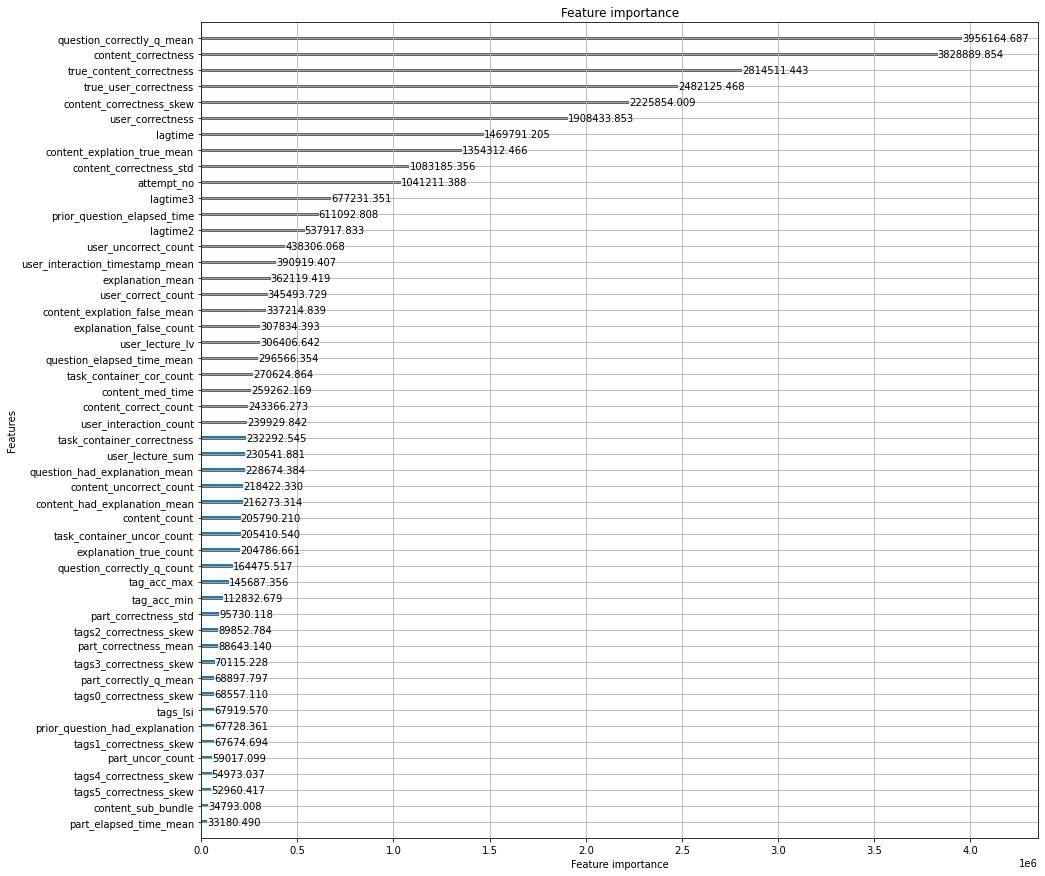

In [78]:
fig,ax = plt.subplots(figsize=(15,15))
lgb.plot_importance(gbm, ax=ax,importance_type='gain',max_num_features=50)
plt.show()

In [79]:
print(psutil.virtual_memory().percent)

38.8


In [80]:
joblib.dump(gbm, '../data/bagging4.3.pkl')
print('Model saved')

Model saved
